<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/320px-Flag_of_Italy.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition italienne du *Huff Post* (2012-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Italie"
huff = huff[huff.pays == edition]
huff.shape

(64880, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

L'Huffington Post        64734
The Huffington Post      119  
Le Huffington Post       14   
허핑턴포스트                   6    
ハフィントンポスト                3    
El Huffington Post       2    
Huffington Post India    1    
HuffPost Brasil          1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

L'Huffington Post        64734
The Huffington Post      119  
Le Huffington Post       14   
허핑턴포스트                   6    
ハフィントンポスト                3    
El Huffington Post       2    
Huffington Post India    1    
HuffPost Brasil          1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(64880, 13)

In [7]:
len(huff) - len(huff[metaHP])

0

Le calcul ci-haut nous indique que la balise `meta` de **tous** les articles de l'édition italienne du *HuffPost* prétendent qu'ils ont été rédigés par l'équipe du *HuffPost*.
<hr>
Examinons-les quand même de plus près en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? L'Huffington Post                                                                      18172
? Redazione, L'Huffington Post                                                           6299 
Di Redazione L'Huffington Post                                                           4000 
? Ansa                                                                                   2853 
Angela Mauro ?                                                                           1440 
Alessandro De Angelis ?                                                                  1320 
? Ilaria Betti, L'Huffington Post                                                        933  
?                                                                                        717  
? Pier Luigi Pisa, L'Huffington Post                                                     574  
Di Redazione L'HuffingtonPost                                                            520  
Pietro Salvatori ?                                

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent un peu moins de **2%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(1116, 1.7200986436498151)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(49311, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? L'Huffington Post                                                                       18172
 ? Redazione, L'Huffington Post                                                            6299 
 Di Redazione L'Huffington Post                                                            4000 
 ? Ilaria Betti, L'Huffington Post                                                         933  
 ? Pier Luigi Pisa, L'Huffington Post                                                      574  
 Di Redazione L'HuffingtonPost                                                             520  
 ? Ansa, L'Huffington Post                                                                 476  
 Di Ilaria Betti L'Huffington Post                                                         472  
 ? Redazione, l'Huffington Post                                                            415  
 ? Silvia De Santis, L'Huffington Post                                                     402  
 DiFlavio Bini L'Huffington Po

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **49&nbsp;311 articles** signés par **2&nbsp;105 signataires différents**.<br>
Cela représente plus des trois quarts de l'ensemble des articles publiés par cette édition du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(49311, 76.003390875462401)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(15569, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? Ansa                                                                                 2853
 Angela Mauro ?                                                                         1440
 Alessandro De Angelis ?                                                                1320
 ?                                                                                      717 
 Pietro Salvatori ?                                                                     517 
 ? Repubblica.it                                                                        482 
 ? La Repubblica                                                                        410 
 Gabriella Cerami ?                                                                     400 
 ? ?                                                                                    399 
 ? espresso.repubblica.it                                                               387 
 ? Corriere della Sera                                                

On constate que lorsqu'il y a un nom de journaliste suivi d'un point d'interrogation, c'est un auteur de l'équipe du *HuffPost Italie*. C'est le cas d'[Angela Mauro](http://www.huffingtonpost.it/author/angela-mauro/) et d'[Alessandro De Angelis](http://www.huffingtonpost.it/author/alessandro-de-angelis/), pour ne nommer que ceux-là.

On va donc considérer que si la variable `byline` se termine par un point d'interrogation, il s'agira d'un auteur qui rédige des articles originaux pour le *HuffPost*.

Isolons ces auteurs.

In [15]:
auteur = huff[metaHP][NONsigneHP].byline.str.endswith(" ?")
huff[metaHP][NONsigneHP][auteur].byline.value_counts(), huff[metaHP][NONsigneHP][auteur].byline.value_counts().sum()

(Angela Mauro ?             1440
 Alessandro De Angelis ?    1320
 Pietro Salvatori ?         517 
 Gabriella Cerami ?         400 
 ? ?                        399 
 Giacomo Talignani ?        176 
 Flavio Bini ?              148 
 Adele Sarno ?              83  
 Laura Eduati ?             78  
 Andrea Bassi ?             72  
 Marco Pasqua ?             43  
 Andrea Punzo ?             40  
 Giacomo Galanti ?          34  
 Giulia Belardelli ?        33  
 Gianni Del Vecchio ?       31  
 Claudio Paudice ?          29  
 Giovanni Valentini ?       20  
 Lucia Annunziata ?         16  
 Howard Fineman ?           7   
 Stefano Baldolini ?        5   
 Linda Varlese ?            4   
 Daniel Marans ?            2   
 Lorenzo Ligato ?           1   
 Willa Frej ?               1   
 Travis Waldron ?           1   
 Kelsey Borresen ?          1   
 Kate Bratskeir ?           1   
 Jordan Schultz ?           1   
 Jo Confino ?               1   
 Kate Sheppard ?            1   
 Lauren Du

Ces auteurs ont donc signé **4&nbsp;908 articles** (4&nbsp;509 articles ci-dessus, auxquels il faut retrancher les 399 articles dont l'auteur est inconnu [«&nbsp;? ?&nbsp;»]).

On peut les ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 4509
HP_oui, (HP_oui/len(huff))*100

(53820, 82.953144266337858)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, ainsi que tous les articles dont on vient d'associer les auteurs au *HuffPost* et qu'on a ajoutés à notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 4509
HP_non, (HP_non/len(huff))*100

(9944, 15.326757090012331)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

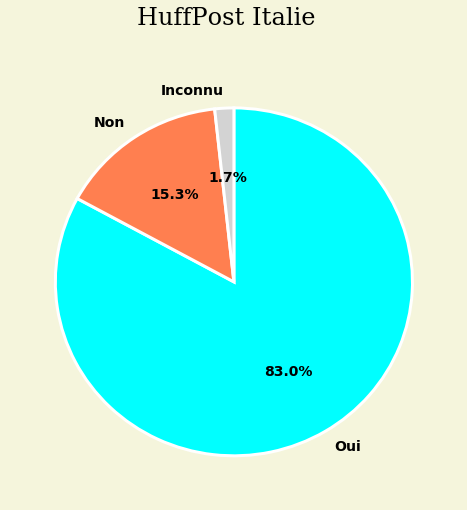

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Italie", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

politica                                                       12584
notizie                                                        8425 
esteri                                                         7599 
cronaca                                                        6587 
italia-politica                                                6035 
culture                                                        5595 
economia                                                       5570 
Matteo Renzi                                                   4980 
video                                                          3725 
italia-economia                                                2932 
italia-culture                                                 2888 
italia-cronaca                                                 2881 
Silvio Berlusconi                                              2779 
people                                                         2397 
la vita com'è                     